In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

# LEAR

In [2]:
df = pd.read_csv(r"Data\EPFToolbox\DE.csv")

In [3]:
df['Date'] = pd.to_datetime(df.Date)

In [4]:
df.index = df.Date

In [5]:
df = df.drop('Date', axis = 1)

In [6]:
df.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [7]:
df_train = df[df.index < dt.datetime(2016, 1, 1)]
df_test = df[df.index >= dt.datetime(2016, 1, 1)]

In [8]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [9]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [10]:
forecast_dates = forecast.index

In [11]:
from epftoolbox.models import LEAR

In [12]:
calibration_window = 2*364

In [13]:
model = LEAR(calibration_window=calibration_window)

In [14]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2016-01-01 - sMAPE: 29.12%  |  MAE: 8.466
2016-01-02 - sMAPE: 53.73%  |  MAE: 8.971
2016-01-03 - sMAPE: 66.04%  |  MAE: 8.006
2016-01-04 - sMAPE: 53.89%  |  MAE: 6.804
2016-01-05 - sMAPE: 44.43%  |  MAE: 5.851
2016-01-06 - sMAPE: 38.47%  |  MAE: 5.402
2016-01-07 - sMAPE: 34.93%  |  MAE: 5.252
2016-01-08 - sMAPE: 32.24%  |  MAE: 5.038
2016-01-09 - sMAPE: 29.51%  |  MAE: 4.733
2016-01-10 - sMAPE: 28.99%  |  MAE: 4.542
2016-01-11 - sMAPE: 26.83%  |  MAE: 4.291
2016-01-12 - sMAPE: 25.44%  |  MAE: 4.165
2016-01-13 - sMAPE: 24.20%  |  MAE: 4.050
2016-01-14 - sMAPE: 22.89%  |  MAE: 3.915
2016-01-15 - sMAPE: 22.19%  |  MAE: 3.943
2016-01-16 - sMAPE: 21.39%  |  MAE: 3.875
2016-01-17 - sMAPE: 20.73%  |  MAE: 3.807
2016-01-18 - sMAPE: 20.09%  |  MAE: 3.786
2016-01-19 - sMAPE: 20.01%  |  MAE: 4.054
2016-01-20 - sMAPE: 19.73%  |  MAE: 4.242
2016-01-21 - sMAPE: 19.44%  |  MAE: 4.395
2016-01-22 - sMAPE: 19.24%  |  MAE: 4.455
2016-01-23 - sMAPE: 18.84%  |  MAE: 4.375
2016-01-24 - sMAPE: 18.35%  |  MAE

2016-07-15 - sMAPE: 18.59%  |  MAE: 3.441
2016-07-16 - sMAPE: 18.53%  |  MAE: 3.433
2016-07-17 - sMAPE: 18.48%  |  MAE: 3.424
2016-07-18 - sMAPE: 18.42%  |  MAE: 3.417
2016-07-19 - sMAPE: 18.35%  |  MAE: 3.410
2016-07-20 - sMAPE: 18.31%  |  MAE: 3.408
2016-07-21 - sMAPE: 18.25%  |  MAE: 3.401
2016-07-22 - sMAPE: 18.18%  |  MAE: 3.390
2016-07-23 - sMAPE: 18.14%  |  MAE: 3.387
2016-07-24 - sMAPE: 18.09%  |  MAE: 3.380
2016-07-25 - sMAPE: 18.02%  |  MAE: 3.371
2016-07-26 - sMAPE: 17.96%  |  MAE: 3.363
2016-07-27 - sMAPE: 17.90%  |  MAE: 3.356
2016-07-28 - sMAPE: 17.84%  |  MAE: 3.350
2016-07-29 - sMAPE: 17.78%  |  MAE: 3.340
2016-07-30 - sMAPE: 17.72%  |  MAE: 3.331
2016-07-31 - sMAPE: 17.66%  |  MAE: 3.322
2016-08-01 - sMAPE: 17.62%  |  MAE: 3.318
2016-08-02 - sMAPE: 17.57%  |  MAE: 3.314
2016-08-03 - sMAPE: 17.50%  |  MAE: 3.303
2016-08-04 - sMAPE: 17.45%  |  MAE: 3.298
2016-08-05 - sMAPE: 17.40%  |  MAE: 3.291
2016-08-06 - sMAPE: 17.36%  |  MAE: 3.285
2016-08-07 - sMAPE: 17.54%  |  MAE

2017-01-27 - sMAPE: 16.15%  |  MAE: 3.920
2017-01-28 - sMAPE: 16.12%  |  MAE: 3.917
2017-01-29 - sMAPE: 16.10%  |  MAE: 3.915
2017-01-30 - sMAPE: 16.09%  |  MAE: 3.920
2017-01-31 - sMAPE: 16.07%  |  MAE: 3.925
2017-02-01 - sMAPE: 16.08%  |  MAE: 3.941
2017-02-02 - sMAPE: 16.06%  |  MAE: 3.940
2017-02-03 - sMAPE: 16.03%  |  MAE: 3.939
2017-02-04 - sMAPE: 16.03%  |  MAE: 3.947
2017-02-05 - sMAPE: 16.01%  |  MAE: 3.944
2017-02-06 - sMAPE: 16.00%  |  MAE: 3.951
2017-02-07 - sMAPE: 15.99%  |  MAE: 3.959
2017-02-08 - sMAPE: 15.98%  |  MAE: 3.968
2017-02-09 - sMAPE: 15.96%  |  MAE: 3.968
2017-02-10 - sMAPE: 15.95%  |  MAE: 3.973
2017-02-11 - sMAPE: 15.93%  |  MAE: 3.972
2017-02-12 - sMAPE: 15.91%  |  MAE: 3.967
2017-02-13 - sMAPE: 15.89%  |  MAE: 3.966
2017-02-14 - sMAPE: 15.89%  |  MAE: 3.973
2017-02-15 - sMAPE: 15.87%  |  MAE: 3.972
2017-02-16 - sMAPE: 15.86%  |  MAE: 3.973
2017-02-17 - sMAPE: 15.84%  |  MAE: 3.972
2017-02-18 - sMAPE: 15.81%  |  MAE: 3.969
2017-02-19 - sMAPE: 15.84%  |  MAE

2017-08-11 - sMAPE: 15.43%  |  MAE: 3.844
2017-08-12 - sMAPE: 15.44%  |  MAE: 3.844
2017-08-13 - sMAPE: 15.44%  |  MAE: 3.844
2017-08-14 - sMAPE: 15.42%  |  MAE: 3.840
2017-08-15 - sMAPE: 15.43%  |  MAE: 3.843
2017-08-16 - sMAPE: 15.42%  |  MAE: 3.843
2017-08-17 - sMAPE: 15.40%  |  MAE: 3.838
2017-08-18 - sMAPE: 15.38%  |  MAE: 3.834
2017-08-19 - sMAPE: 15.47%  |  MAE: 3.845
2017-08-20 - sMAPE: 15.59%  |  MAE: 3.853
2017-08-21 - sMAPE: 15.59%  |  MAE: 3.854
2017-08-22 - sMAPE: 15.58%  |  MAE: 3.853
2017-08-23 - sMAPE: 15.56%  |  MAE: 3.850
2017-08-24 - sMAPE: 15.55%  |  MAE: 3.846
2017-08-25 - sMAPE: 15.52%  |  MAE: 3.842
2017-08-26 - sMAPE: 15.51%  |  MAE: 3.839
2017-08-27 - sMAPE: 15.50%  |  MAE: 3.837
2017-08-28 - sMAPE: 15.48%  |  MAE: 3.834
2017-08-29 - sMAPE: 15.47%  |  MAE: 3.832
2017-08-30 - sMAPE: 15.45%  |  MAE: 3.828
2017-08-31 - sMAPE: 15.44%  |  MAE: 3.828
2017-09-01 - sMAPE: 15.42%  |  MAE: 3.824
2017-09-02 - sMAPE: 15.40%  |  MAE: 3.820
2017-09-03 - sMAPE: 15.39%  |  MAE

In [15]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,26.666729,23.986908,22.635092,20.793926,20.339709,22.332174,25.389837,33.122535,33.771187,35.61885,...,35.738079,37.036729,40.470264,45.797633,48.951985,45.317978,38.247845,34.67465,34.676541,29.492817
2016-01-02,23.133168,18.694226,15.955806,12.984922,11.242331,6.951249,-4.838222,-8.035362,-3.962613,-0.343581,...,6.462684,8.288715,13.190632,21.578275,19.359848,11.405173,4.226042,4.875309,12.648518,9.253814
2016-01-03,4.079208,-2.179723,-2.176293,-3.515668,-3.612393,-8.205467,-10.842263,-5.640433,-3.599793,1.86782,...,11.524892,12.118641,15.664152,23.810652,26.690344,23.105832,18.348713,18.718915,21.201159,12.679532
2016-01-04,11.437024,8.307346,6.359805,5.769222,5.606078,11.461153,21.254008,27.427488,29.316998,29.24545,...,30.081199,32.354026,35.136313,42.073513,44.377879,43.036778,38.028987,33.714938,31.875002,25.955595
2016-01-05,23.189916,21.370033,19.522677,18.639465,19.261991,21.88804,28.210705,39.046855,40.715034,38.873774,...,35.999731,37.106839,39.11034,45.091795,46.475553,45.058179,37.537629,32.136272,29.76631,24.263953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,15.072813,11.662009,8.884299,10.04596,12.329547,15.787217,22.577518,26.381378,28.209191,27.523374,...,30.151626,31.93034,34.648981,38.050647,39.183611,39.016561,35.249086,31.670053,29.380801,23.863923
2017-12-28,32.045012,29.844644,27.478249,26.543673,25.2359,26.474622,29.537151,36.852408,39.893487,37.913048,...,34.883543,35.716767,36.445845,41.513865,41.186403,37.238074,31.144005,28.846217,29.427653,23.846732
2017-12-29,11.151604,9.873527,7.846653,9.249871,11.657094,15.236387,21.856565,29.501483,32.838982,32.784548,...,31.570176,32.469933,34.197747,39.244591,36.737097,32.540789,28.705525,26.587003,26.167342,19.019769


In [16]:
forecast.to_csv("Resultados/de_epftoolbox_final_2_anos_ventana.csv")

In [17]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [18]:
forecast_dates = forecast.index

In [19]:
calibration_window = 1*364

In [20]:
model = LEAR(calibration_window=calibration_window)

In [21]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2016-01-01 - sMAPE: 26.96%  |  MAE: 7.723
2016-01-02 - sMAPE: 41.16%  |  MAE: 7.403
2016-01-03 - sMAPE: 61.92%  |  MAE: 7.406
2016-01-04 - sMAPE: 51.53%  |  MAE: 6.436
2016-01-05 - sMAPE: 42.54%  |  MAE: 5.579
2016-01-06 - sMAPE: 36.89%  |  MAE: 5.156
2016-01-07 - sMAPE: 33.48%  |  MAE: 4.991
2016-01-08 - sMAPE: 30.96%  |  MAE: 4.773
2016-01-09 - sMAPE: 28.43%  |  MAE: 4.515
2016-01-10 - sMAPE: 27.43%  |  MAE: 4.287
2016-01-11 - sMAPE: 25.42%  |  MAE: 4.060
2016-01-12 - sMAPE: 24.16%  |  MAE: 3.957
2016-01-13 - sMAPE: 23.02%  |  MAE: 3.875
2016-01-14 - sMAPE: 21.78%  |  MAE: 3.745
2016-01-15 - sMAPE: 21.16%  |  MAE: 3.794
2016-01-16 - sMAPE: 20.60%  |  MAE: 3.792
2016-01-17 - sMAPE: 19.91%  |  MAE: 3.723
2016-01-18 - sMAPE: 19.36%  |  MAE: 3.726
2016-01-19 - sMAPE: 19.23%  |  MAE: 3.960
2016-01-20 - sMAPE: 19.06%  |  MAE: 4.171
2016-01-21 - sMAPE: 18.89%  |  MAE: 4.371
2016-01-22 - sMAPE: 18.80%  |  MAE: 4.456
2016-01-23 - sMAPE: 18.36%  |  MAE: 4.372
2016-01-24 - sMAPE: 18.00%  |  MAE

2016-07-15 - sMAPE: 17.67%  |  MAE: 3.412
2016-07-16 - sMAPE: 17.61%  |  MAE: 3.403
2016-07-17 - sMAPE: 17.56%  |  MAE: 3.393
2016-07-18 - sMAPE: 17.49%  |  MAE: 3.383
2016-07-19 - sMAPE: 17.44%  |  MAE: 3.377
2016-07-20 - sMAPE: 17.39%  |  MAE: 3.372
2016-07-21 - sMAPE: 17.34%  |  MAE: 3.366
2016-07-22 - sMAPE: 17.27%  |  MAE: 3.356
2016-07-23 - sMAPE: 17.24%  |  MAE: 3.354
2016-07-24 - sMAPE: 17.19%  |  MAE: 3.347
2016-07-25 - sMAPE: 17.13%  |  MAE: 3.337
2016-07-26 - sMAPE: 17.06%  |  MAE: 3.327
2016-07-27 - sMAPE: 17.01%  |  MAE: 3.319
2016-07-28 - sMAPE: 16.95%  |  MAE: 3.312
2016-07-29 - sMAPE: 16.89%  |  MAE: 3.303
2016-07-30 - sMAPE: 16.84%  |  MAE: 3.295
2016-07-31 - sMAPE: 16.79%  |  MAE: 3.287
2016-08-01 - sMAPE: 16.74%  |  MAE: 3.279
2016-08-02 - sMAPE: 16.70%  |  MAE: 3.277
2016-08-03 - sMAPE: 16.64%  |  MAE: 3.268
2016-08-04 - sMAPE: 16.59%  |  MAE: 3.261
2016-08-05 - sMAPE: 16.55%  |  MAE: 3.256
2016-08-06 - sMAPE: 16.51%  |  MAE: 3.250
2016-08-07 - sMAPE: 16.70%  |  MAE

2017-01-27 - sMAPE: 16.18%  |  MAE: 4.073
2017-01-28 - sMAPE: 16.16%  |  MAE: 4.072
2017-01-29 - sMAPE: 16.15%  |  MAE: 4.072
2017-01-30 - sMAPE: 16.14%  |  MAE: 4.078
2017-01-31 - sMAPE: 16.12%  |  MAE: 4.081
2017-02-01 - sMAPE: 16.12%  |  MAE: 4.093
2017-02-02 - sMAPE: 16.09%  |  MAE: 4.090
2017-02-03 - sMAPE: 16.07%  |  MAE: 4.088
2017-02-04 - sMAPE: 16.07%  |  MAE: 4.096
2017-02-05 - sMAPE: 16.05%  |  MAE: 4.094
2017-02-06 - sMAPE: 16.04%  |  MAE: 4.102
2017-02-07 - sMAPE: 16.02%  |  MAE: 4.103
2017-02-08 - sMAPE: 16.02%  |  MAE: 4.114
2017-02-09 - sMAPE: 15.99%  |  MAE: 4.114
2017-02-10 - sMAPE: 15.98%  |  MAE: 4.116
2017-02-11 - sMAPE: 15.97%  |  MAE: 4.115
2017-02-12 - sMAPE: 15.94%  |  MAE: 4.109
2017-02-13 - sMAPE: 15.93%  |  MAE: 4.110
2017-02-14 - sMAPE: 15.93%  |  MAE: 4.117
2017-02-15 - sMAPE: 15.91%  |  MAE: 4.120
2017-02-16 - sMAPE: 15.90%  |  MAE: 4.119
2017-02-17 - sMAPE: 15.88%  |  MAE: 4.116
2017-02-18 - sMAPE: 15.86%  |  MAE: 4.114
2017-02-19 - sMAPE: 15.88%  |  MAE

2017-08-11 - sMAPE: 15.50%  |  MAE: 3.955
2017-08-12 - sMAPE: 15.49%  |  MAE: 3.954
2017-08-13 - sMAPE: 15.51%  |  MAE: 3.956
2017-08-14 - sMAPE: 15.49%  |  MAE: 3.952
2017-08-15 - sMAPE: 15.50%  |  MAE: 3.956
2017-08-16 - sMAPE: 15.49%  |  MAE: 3.954
2017-08-17 - sMAPE: 15.47%  |  MAE: 3.950
2017-08-18 - sMAPE: 15.45%  |  MAE: 3.945
2017-08-19 - sMAPE: 15.53%  |  MAE: 3.954
2017-08-20 - sMAPE: 15.65%  |  MAE: 3.962
2017-08-21 - sMAPE: 15.65%  |  MAE: 3.961
2017-08-22 - sMAPE: 15.63%  |  MAE: 3.958
2017-08-23 - sMAPE: 15.61%  |  MAE: 3.954
2017-08-24 - sMAPE: 15.59%  |  MAE: 3.950
2017-08-25 - sMAPE: 15.57%  |  MAE: 3.945
2017-08-26 - sMAPE: 15.55%  |  MAE: 3.941
2017-08-27 - sMAPE: 15.54%  |  MAE: 3.938
2017-08-28 - sMAPE: 15.53%  |  MAE: 3.936
2017-08-29 - sMAPE: 15.51%  |  MAE: 3.933
2017-08-30 - sMAPE: 15.49%  |  MAE: 3.928
2017-08-31 - sMAPE: 15.48%  |  MAE: 3.928
2017-09-01 - sMAPE: 15.46%  |  MAE: 3.924
2017-09-02 - sMAPE: 15.44%  |  MAE: 3.919
2017-09-03 - sMAPE: 15.42%  |  MAE

In [22]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,26.800646,23.017014,22.076393,20.237317,19.914095,21.528747,26.351888,34.404455,34.472149,35.272203,...,33.748924,35.508584,37.760225,44.214868,49.06621,43.729702,38.29142,33.68503,34.981758,29.451578
2016-01-02,23.121078,19.793812,16.758864,14.027484,11.97013,7.101274,0.357318,-5.885534,2.870929,8.618613,...,10.762641,9.880593,12.955492,18.861005,16.259318,16.735822,6.736101,9.570213,15.841306,15.174868
2016-01-03,10.180344,1.019232,-0.578846,-2.074326,-2.687462,-3.490712,-8.912884,-9.291086,-6.886121,0.101552,...,6.046351,8.02216,12.492537,20.957557,24.652492,20.708866,15.986768,16.431619,19.144883,15.367206
2016-01-04,11.532637,6.510901,5.91836,5.8706,7.382438,11.967275,19.393092,26.862004,27.834707,27.660765,...,30.796306,32.279972,34.570338,40.81358,43.411065,40.644777,37.99915,32.899116,31.333186,25.606644
2016-01-05,23.514805,21.685806,20.545949,19.226623,19.941137,21.736895,29.397738,39.867625,40.812724,38.611107,...,36.581769,38.29839,39.658066,45.32714,45.580735,43.917433,36.91081,30.877035,29.276876,25.013611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,11.571075,6.169316,4.857117,3.804649,7.020195,12.055817,18.529299,20.20717,22.018875,23.069856,...,28.525783,31.730202,35.028258,39.109433,40.173959,40.479742,38.421375,35.164157,32.006723,27.017139
2017-12-28,30.242266,27.227295,26.35921,24.00114,24.365797,26.110278,29.758924,34.706013,37.836806,34.430831,...,33.241056,34.817453,36.438271,42.429118,41.895607,38.832403,32.441421,29.690642,28.781834,22.738459
2017-12-29,10.583442,7.646774,7.741186,9.927817,13.352282,16.046044,20.752895,24.424924,28.630844,31.38026,...,29.956855,28.90525,33.255757,38.638845,36.831732,34.239803,29.284866,26.781464,25.298583,17.197814


In [23]:
forecast.to_csv("Resultados/de_epftoolbox_final_1_ano_ventana.csv")

In [24]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [25]:
forecast_dates = forecast.index

In [26]:
calibration_window = 182

In [27]:
model = LEAR(calibration_window=calibration_window)

In [28]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2016-01-01 - sMAPE: 31.16%  |  MAE: 9.106
2016-01-02 - sMAPE: 48.89%  |  MAE: 8.733
2016-01-03 - sMAPE: 63.06%  |  MAE: 7.940
2016-01-04 - sMAPE: 52.71%  |  MAE: 6.952
2016-01-05 - sMAPE: 43.44%  |  MAE: 5.975
2016-01-06 - sMAPE: 37.70%  |  MAE: 5.518
2016-01-07 - sMAPE: 34.02%  |  MAE: 5.290
2016-01-08 - sMAPE: 31.50%  |  MAE: 5.031
2016-01-09 - sMAPE: 29.21%  |  MAE: 4.825
2016-01-10 - sMAPE: 27.90%  |  MAE: 4.597
2016-01-11 - sMAPE: 26.03%  |  MAE: 4.401
2016-01-12 - sMAPE: 24.75%  |  MAE: 4.281
2016-01-13 - sMAPE: 23.53%  |  MAE: 4.162
2016-01-14 - sMAPE: 22.25%  |  MAE: 4.006
2016-01-15 - sMAPE: 21.59%  |  MAE: 4.033
2016-01-16 - sMAPE: 21.20%  |  MAE: 4.078
2016-01-17 - sMAPE: 20.62%  |  MAE: 4.035
2016-01-18 - sMAPE: 20.13%  |  MAE: 4.054
2016-01-19 - sMAPE: 20.02%  |  MAE: 4.307
2016-01-20 - sMAPE: 19.93%  |  MAE: 4.555
2016-01-21 - sMAPE: 19.86%  |  MAE: 4.799
2016-01-22 - sMAPE: 19.70%  |  MAE: 4.849
2016-01-23 - sMAPE: 19.27%  |  MAE: 4.758
2016-01-24 - sMAPE: 18.94%  |  MAE

2016-07-15 - sMAPE: 17.56%  |  MAE: 3.527
2016-07-16 - sMAPE: 17.50%  |  MAE: 3.516
2016-07-17 - sMAPE: 17.46%  |  MAE: 3.508
2016-07-18 - sMAPE: 17.41%  |  MAE: 3.501
2016-07-19 - sMAPE: 17.35%  |  MAE: 3.493
2016-07-20 - sMAPE: 17.29%  |  MAE: 3.482
2016-07-21 - sMAPE: 17.26%  |  MAE: 3.484
2016-07-22 - sMAPE: 17.21%  |  MAE: 3.477
2016-07-23 - sMAPE: 17.20%  |  MAE: 3.480
2016-07-24 - sMAPE: 17.17%  |  MAE: 3.476
2016-07-25 - sMAPE: 17.14%  |  MAE: 3.474
2016-07-26 - sMAPE: 17.07%  |  MAE: 3.464
2016-07-27 - sMAPE: 17.04%  |  MAE: 3.462
2016-07-28 - sMAPE: 16.97%  |  MAE: 3.451
2016-07-29 - sMAPE: 16.93%  |  MAE: 3.444
2016-07-30 - sMAPE: 16.89%  |  MAE: 3.439
2016-07-31 - sMAPE: 16.84%  |  MAE: 3.431
2016-08-01 - sMAPE: 16.79%  |  MAE: 3.422
2016-08-02 - sMAPE: 16.75%  |  MAE: 3.419
2016-08-03 - sMAPE: 16.71%  |  MAE: 3.413
2016-08-04 - sMAPE: 16.65%  |  MAE: 3.403
2016-08-05 - sMAPE: 16.62%  |  MAE: 3.401
2016-08-06 - sMAPE: 16.58%  |  MAE: 3.393
2016-08-07 - sMAPE: 16.77%  |  MAE

2017-01-27 - sMAPE: 16.31%  |  MAE: 4.211
2017-01-28 - sMAPE: 16.28%  |  MAE: 4.208
2017-01-29 - sMAPE: 16.26%  |  MAE: 4.206
2017-01-30 - sMAPE: 16.24%  |  MAE: 4.207
2017-01-31 - sMAPE: 16.22%  |  MAE: 4.210
2017-02-01 - sMAPE: 16.21%  |  MAE: 4.220
2017-02-02 - sMAPE: 16.19%  |  MAE: 4.218
2017-02-03 - sMAPE: 16.19%  |  MAE: 4.223
2017-02-04 - sMAPE: 16.18%  |  MAE: 4.230
2017-02-05 - sMAPE: 16.17%  |  MAE: 4.233
2017-02-06 - sMAPE: 16.16%  |  MAE: 4.241
2017-02-07 - sMAPE: 16.14%  |  MAE: 4.239
2017-02-08 - sMAPE: 16.13%  |  MAE: 4.246
2017-02-09 - sMAPE: 16.11%  |  MAE: 4.247
2017-02-10 - sMAPE: 16.09%  |  MAE: 4.249
2017-02-11 - sMAPE: 16.08%  |  MAE: 4.248
2017-02-12 - sMAPE: 16.06%  |  MAE: 4.242
2017-02-13 - sMAPE: 16.04%  |  MAE: 4.242
2017-02-14 - sMAPE: 16.04%  |  MAE: 4.250
2017-02-15 - sMAPE: 16.02%  |  MAE: 4.249
2017-02-16 - sMAPE: 16.00%  |  MAE: 4.248
2017-02-17 - sMAPE: 15.98%  |  MAE: 4.244
2017-02-18 - sMAPE: 15.97%  |  MAE: 4.246
2017-02-19 - sMAPE: 16.00%  |  MAE

2017-08-11 - sMAPE: 15.93%  |  MAE: 4.136
2017-08-12 - sMAPE: 15.93%  |  MAE: 4.135
2017-08-13 - sMAPE: 15.95%  |  MAE: 4.137
2017-08-14 - sMAPE: 15.93%  |  MAE: 4.133
2017-08-15 - sMAPE: 15.94%  |  MAE: 4.136
2017-08-16 - sMAPE: 15.93%  |  MAE: 4.135
2017-08-17 - sMAPE: 15.91%  |  MAE: 4.129
2017-08-18 - sMAPE: 15.89%  |  MAE: 4.125
2017-08-19 - sMAPE: 15.97%  |  MAE: 4.134
2017-08-20 - sMAPE: 16.10%  |  MAE: 4.146
2017-08-21 - sMAPE: 16.10%  |  MAE: 4.145
2017-08-22 - sMAPE: 16.09%  |  MAE: 4.143
2017-08-23 - sMAPE: 16.07%  |  MAE: 4.138
2017-08-24 - sMAPE: 16.05%  |  MAE: 4.134
2017-08-25 - sMAPE: 16.03%  |  MAE: 4.131
2017-08-26 - sMAPE: 16.02%  |  MAE: 4.129
2017-08-27 - sMAPE: 16.01%  |  MAE: 4.127
2017-08-28 - sMAPE: 16.00%  |  MAE: 4.126
2017-08-29 - sMAPE: 15.99%  |  MAE: 4.124
2017-08-30 - sMAPE: 15.97%  |  MAE: 4.121
2017-08-31 - sMAPE: 15.96%  |  MAE: 4.121
2017-09-01 - sMAPE: 15.95%  |  MAE: 4.119
2017-09-02 - sMAPE: 15.93%  |  MAE: 4.116
2017-09-03 - sMAPE: 15.91%  |  MAE

In [29]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,28.436228,24.810469,23.983783,22.598107,20.483826,23.187151,27.682032,35.450649,36.236935,40.78403,...,34.082971,37.051814,39.20106,47.23026,49.83389,45.037529,39.973014,35.778371,35.277089,30.334572
2016-01-02,23.405564,20.468115,19.009661,14.014677,11.371065,8.148402,-0.725398,-8.751263,-1.213871,-0.526574,...,9.473518,6.905962,12.370616,13.067872,9.799336,5.709888,15.745542,10.203163,17.935851,19.79075
2016-01-03,11.959595,2.317529,2.006383,-0.721937,-3.595687,-6.655053,-11.413849,-8.543342,-3.433697,0.322251,...,10.20822,7.930471,13.722443,19.830465,25.162755,21.75222,19.431802,19.785353,23.66684,14.350029
2016-01-04,11.52671,7.329245,7.150824,1.528723,4.663506,12.200673,19.411781,25.167532,27.908754,27.719983,...,27.78098,31.258224,33.98639,44.051552,43.44677,41.106419,36.196906,32.389171,30.278768,25.287841
2016-01-05,23.220573,21.293522,21.249429,19.499989,20.431621,22.2783,29.0683,39.120142,40.844603,39.409797,...,34.234475,36.8469,39.642633,45.072147,44.213814,42.836883,37.225544,32.656188,30.187827,25.503195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,13.697016,4.326663,2.182542,3.662664,8.133899,16.035658,20.081183,24.061774,25.294926,23.238972,...,31.652959,33.684893,36.641831,40.381296,41.688772,40.869177,38.792044,35.156178,32.594063,27.956322
2017-12-28,29.312944,25.864917,24.334792,23.502728,24.12014,25.12494,27.614329,32.755247,39.948831,31.350047,...,32.303821,35.872166,36.427393,41.412236,39.463151,37.297484,29.841809,25.508867,25.614146,19.696718
2017-12-29,10.018728,3.632277,6.160994,8.482273,13.612405,14.755367,15.910472,24.165081,32.937942,32.371284,...,30.225271,31.822708,36.679541,42.680758,35.287777,32.38586,29.281185,26.15163,23.660809,16.418311


In [30]:
forecast.to_csv("Resultados/de_epftoolbox_final_6_meses_ventana.csv")

# Estandarización móvil

In [31]:
df = pd.read_csv("Data\EPFToolbox\DE.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [32]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [33]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [34]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2012-01-09 00:00:00,34.97,2072.00,16382.00,2012-01-09,0
1,2012-01-09 01:00:00,33.43,1929.75,15410.50,2012-01-09,1
2,2012-01-09 02:00:00,32.74,1856.00,15595.00,2012-01-09,2
3,2012-01-09 03:00:00,32.46,1808.75,16521.00,2012-01-09,3
4,2012-01-09 04:00:00,32.50,1765.75,17700.75,2012-01-09,4
...,...,...,...,...,...,...
52411,2017-12-31 19:00:00,7.92,1300.00,16601.00,2017-12-31,19
52412,2017-12-31 20:00:00,4.06,1261.00,15977.75,2017-12-31,20
52413,2017-12-31 21:00:00,5.30,1243.25,15715.00,2017-12-31,21
52414,2017-12-31 22:00:00,1.86,1250.50,15876.00,2017-12-31,22


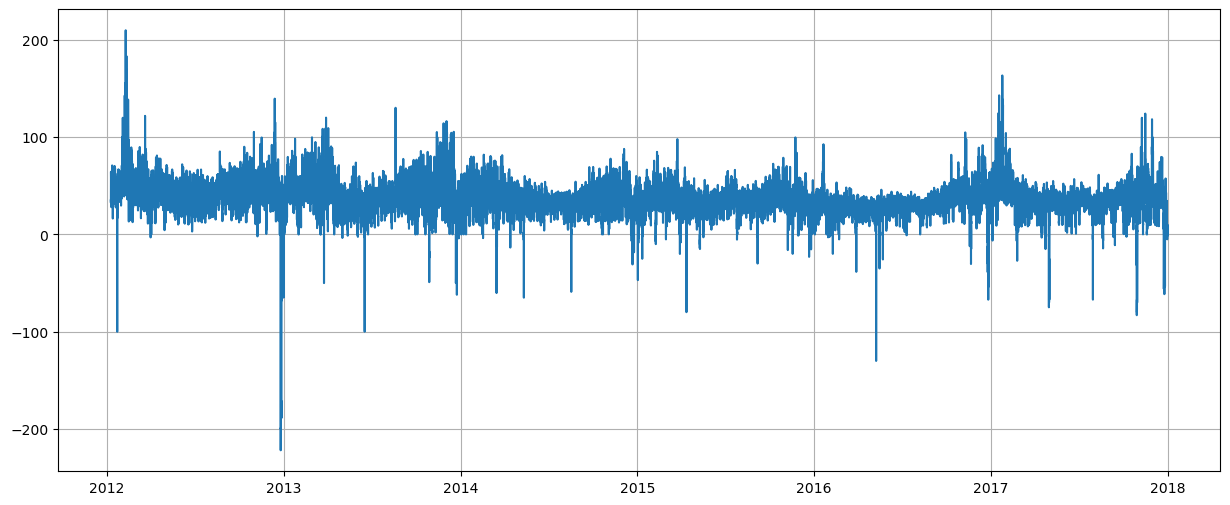

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

Se añaden variables auxiliares

In [36]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_168'] = df.Price.shift(168)

In [37]:
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, x in enumerate(names):
    df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [38]:
for hora in range(24):
    df['Price_hora_'+str(hora)] = np.nan

for fecha in df['Simple Date'].unique():
    df_fecha = df[df['Simple Date'] == fecha]
    
    for hora in df_fecha.Hour.unique():
        Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
        df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [39]:
for col in ['Price_hora_'+str(hora) for hora in range(24)]:
    df[col+"_"+str(24)] = df[col].shift(24)
    df[col+"_"+str(48)] = df[col].shift(48)
    df[col+"_"+str(72)] = df[col].shift(72)
    df[col+"_"+str(168)] = df[col].shift(168)

In [40]:
for hora in range(24):
    df['Exogenous 1_hora_'+str(hora)] = np.nan

for fecha in df['Simple Date'].unique():
    df_fecha = df[df['Simple Date'] == fecha]
    
    for hora in df_fecha.Hour.unique():
        Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
        df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [41]:
for hora in range(24):
    df['Exogenous 2_hora_'+str(hora)] = np.nan

for fecha in df['Simple Date'].unique():
    df_fecha = df[df['Simple Date'] == fecha]
    
    for hora in df_fecha.Hour.unique():
        Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
        df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [42]:
for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
    df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
    df[col+"_"+str(168)] = df[col].shift(168)
for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
    df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
    df[col+"_"+str(168)] = df[col].shift(168)

In [43]:
list(df.columns)

['Date',
 'Price',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
 'Price_24',
 'Price_48',
 'Price_72',
 'Price_168',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'Price_hora_0',
 'Price_hora_1',
 'Price_hora_2',
 'Price_hora_3',
 'Price_hora_4',
 'Price_hora_5',
 'Price_hora_6',
 'Price_hora_7',
 'Price_hora_8',
 'Price_hora_9',
 'Price_hora_10',
 'Price_hora_11',
 'Price_hora_12',
 'Price_hora_13',
 'Price_hora_14',
 'Price_hora_15',
 'Price_hora_16',
 'Price_hora_17',
 'Price_hora_18',
 'Price_hora_19',
 'Price_hora_20',
 'Price_hora_21',
 'Price_hora_22',
 'Price_hora_23',
 'Price_hora_0_24',
 'Price_hora_0_48',
 'Price_hora_0_72',
 'Price_hora_0_168',
 'Price_hora_1_24',
 'Price_hora_1_48',
 'Price_hora_1_72',
 'Price_hora_1_168',
 'Price_hora_2_24',
 'Price_hora_2_48',
 'Price_hora_2_72',
 'Price_hora_2_168',
 'Price_hora_3_24',
 'Price_hora_3_48',
 'Price_hora_3_72',
 'Price_hora_3_168',
 'Price_hora_4_24',
 'Price_hora_4_48',


In [44]:
columnas = ['Date',
 'Price',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
 'Price_24',
 'Price_48',
 'Price_72',
 'Price_168',
 'Price_hora_0',
 'Price_hora_1',
 'Price_hora_2',
 'Price_hora_3',
 'Price_hora_4',
 'Price_hora_5',
 'Price_hora_6',
 'Price_hora_7',
 'Price_hora_8',
 'Price_hora_9',
 'Price_hora_10',
 'Price_hora_11',
 'Price_hora_12',
 'Price_hora_13',
 'Price_hora_14',
 'Price_hora_15',
 'Price_hora_16',
 'Price_hora_17',
 'Price_hora_18',
 'Price_hora_19',
 'Price_hora_20',
 'Price_hora_21',
 'Price_hora_22',
 'Price_hora_23',
 'Price_hora_0_24',
 'Price_hora_0_48',
 'Price_hora_0_72',
 'Price_hora_0_168',
 'Price_hora_1_24',
 'Price_hora_1_48',
 'Price_hora_1_72',
 'Price_hora_1_168',
 'Price_hora_2_24',
 'Price_hora_2_48',
 'Price_hora_2_72',
 'Price_hora_2_168',
 'Price_hora_3_24',
 'Price_hora_3_48',
 'Price_hora_3_72',
 'Price_hora_3_168',
 'Price_hora_4_24',
 'Price_hora_4_48',
 'Price_hora_4_72',
 'Price_hora_4_168',
 'Price_hora_5_24',
 'Price_hora_5_48',
 'Price_hora_5_72',
 'Price_hora_5_168',
 'Price_hora_6_24',
 'Price_hora_6_48',
 'Price_hora_6_72',
 'Price_hora_6_168',
 'Price_hora_7_24',
 'Price_hora_7_48',
 'Price_hora_7_72',
 'Price_hora_7_168',
 'Price_hora_8_24',
 'Price_hora_8_48',
 'Price_hora_8_72',
 'Price_hora_8_168',
 'Price_hora_9_24',
 'Price_hora_9_48',
 'Price_hora_9_72',
 'Price_hora_9_168',
 'Price_hora_10_24',
 'Price_hora_10_48',
 'Price_hora_10_72',
 'Price_hora_10_168',
 'Price_hora_11_24',
 'Price_hora_11_48',
 'Price_hora_11_72',
 'Price_hora_11_168',
 'Price_hora_12_24',
 'Price_hora_12_48',
 'Price_hora_12_72',
 'Price_hora_12_168',
 'Price_hora_13_24',
 'Price_hora_13_48',
 'Price_hora_13_72',
 'Price_hora_13_168',
 'Price_hora_14_24',
 'Price_hora_14_48',
 'Price_hora_14_72',
 'Price_hora_14_168',
 'Price_hora_15_24',
 'Price_hora_15_48',
 'Price_hora_15_72',
 'Price_hora_15_168',
 'Price_hora_16_24',
 'Price_hora_16_48',
 'Price_hora_16_72',
 'Price_hora_16_168',
 'Price_hora_17_24',
 'Price_hora_17_48',
 'Price_hora_17_72',
 'Price_hora_17_168',
 'Price_hora_18_24',
 'Price_hora_18_48',
 'Price_hora_18_72',
 'Price_hora_18_168',
 'Price_hora_19_24',
 'Price_hora_19_48',
 'Price_hora_19_72',
 'Price_hora_19_168',
 'Price_hora_20_24',
 'Price_hora_20_48',
 'Price_hora_20_72',
 'Price_hora_20_168',
 'Price_hora_21_24',
 'Price_hora_21_48',
 'Price_hora_21_72',
 'Price_hora_21_168',
 'Price_hora_22_24',
 'Price_hora_22_48',
 'Price_hora_22_72',
 'Price_hora_22_168',
 'Price_hora_23_24',
 'Price_hora_23_48',
 'Price_hora_23_72',
 'Price_hora_23_168',
 'Exogenous 1_hora_0',
 'Exogenous 1_hora_1',
 'Exogenous 1_hora_2',
 'Exogenous 1_hora_3',
 'Exogenous 1_hora_4',
 'Exogenous 1_hora_5',
 'Exogenous 1_hora_6',
 'Exogenous 1_hora_7',
 'Exogenous 1_hora_8',
 'Exogenous 1_hora_9',
 'Exogenous 1_hora_10',
 'Exogenous 1_hora_11',
 'Exogenous 1_hora_12',
 'Exogenous 1_hora_13',
 'Exogenous 1_hora_14',
 'Exogenous 1_hora_15',
 'Exogenous 1_hora_16',
 'Exogenous 1_hora_17',
 'Exogenous 1_hora_18',
 'Exogenous 1_hora_19',
 'Exogenous 1_hora_20',
 'Exogenous 1_hora_21',
 'Exogenous 1_hora_22',
 'Exogenous 1_hora_23',
 'Exogenous 2_hora_0',
 'Exogenous 2_hora_1',
 'Exogenous 2_hora_2',
 'Exogenous 2_hora_3',
 'Exogenous 2_hora_4',
 'Exogenous 2_hora_5',
 'Exogenous 2_hora_6',
 'Exogenous 2_hora_7',
 'Exogenous 2_hora_8',
 'Exogenous 2_hora_9',
 'Exogenous 2_hora_10',
 'Exogenous 2_hora_11',
 'Exogenous 2_hora_12',
 'Exogenous 2_hora_13',
 'Exogenous 2_hora_14',
 'Exogenous 2_hora_15',
 'Exogenous 2_hora_16',
 'Exogenous 2_hora_17',
 'Exogenous 2_hora_18',
 'Exogenous 2_hora_19',
 'Exogenous 2_hora_20',
 'Exogenous 2_hora_21',
 'Exogenous 2_hora_22',
 'Exogenous 2_hora_23',
 'Exogenous 1_hora_0_24',
 'Exogenous 1_hora_0_168',
 'Exogenous 1_hora_1_24',
 'Exogenous 1_hora_1_168',
 'Exogenous 1_hora_2_24',
 'Exogenous 1_hora_2_168',
 'Exogenous 1_hora_3_24',
 'Exogenous 1_hora_3_168',
 'Exogenous 1_hora_4_24',
 'Exogenous 1_hora_4_168',
 'Exogenous 1_hora_5_24',
 'Exogenous 1_hora_5_168',
 'Exogenous 1_hora_6_24',
 'Exogenous 1_hora_6_168',
 'Exogenous 1_hora_7_24',
 'Exogenous 1_hora_7_168',
 'Exogenous 1_hora_8_24',
 'Exogenous 1_hora_8_168',
 'Exogenous 1_hora_9_24',
 'Exogenous 1_hora_9_168',
 'Exogenous 1_hora_10_24',
 'Exogenous 1_hora_10_168',
 'Exogenous 1_hora_11_24',
 'Exogenous 1_hora_11_168',
 'Exogenous 1_hora_12_24',
 'Exogenous 1_hora_12_168',
 'Exogenous 1_hora_13_24',
 'Exogenous 1_hora_13_168',
 'Exogenous 1_hora_14_24',
 'Exogenous 1_hora_14_168',
 'Exogenous 1_hora_15_24',
 'Exogenous 1_hora_15_168',
 'Exogenous 1_hora_16_24',
 'Exogenous 1_hora_16_168',
 'Exogenous 1_hora_17_24',
 'Exogenous 1_hora_17_168',
 'Exogenous 1_hora_18_24',
 'Exogenous 1_hora_18_168',
 'Exogenous 1_hora_19_24',
 'Exogenous 1_hora_19_168',
 'Exogenous 1_hora_20_24',
 'Exogenous 1_hora_20_168',
 'Exogenous 1_hora_21_24',
 'Exogenous 1_hora_21_168',
 'Exogenous 1_hora_22_24',
 'Exogenous 1_hora_22_168',
 'Exogenous 1_hora_23_24',
 'Exogenous 1_hora_23_168',
 'Exogenous 2_hora_0_24',
 'Exogenous 2_hora_0_168',
 'Exogenous 2_hora_1_24',
 'Exogenous 2_hora_1_168',
 'Exogenous 2_hora_2_24',
 'Exogenous 2_hora_2_168',
 'Exogenous 2_hora_3_24',
 'Exogenous 2_hora_3_168',
 'Exogenous 2_hora_4_24',
 'Exogenous 2_hora_4_168',
 'Exogenous 2_hora_5_24',
 'Exogenous 2_hora_5_168',
 'Exogenous 2_hora_6_24',
 'Exogenous 2_hora_6_168',
 'Exogenous 2_hora_7_24',
 'Exogenous 2_hora_7_168',
 'Exogenous 2_hora_8_24',
 'Exogenous 2_hora_8_168',
 'Exogenous 2_hora_9_24',
 'Exogenous 2_hora_9_168',
 'Exogenous 2_hora_10_24',
 'Exogenous 2_hora_10_168',
 'Exogenous 2_hora_11_24',
 'Exogenous 2_hora_11_168',
 'Exogenous 2_hora_12_24',
 'Exogenous 2_hora_12_168',
 'Exogenous 2_hora_13_24',
 'Exogenous 2_hora_13_168',
 'Exogenous 2_hora_14_24',
 'Exogenous 2_hora_14_168',
 'Exogenous 2_hora_15_24',
 'Exogenous 2_hora_15_168',
 'Exogenous 2_hora_16_24',
 'Exogenous 2_hora_16_168',
 'Exogenous 2_hora_17_24',
 'Exogenous 2_hora_17_168',
 'Exogenous 2_hora_18_24',
 'Exogenous 2_hora_18_168',
 'Exogenous 2_hora_19_24',
 'Exogenous 2_hora_19_168',
 'Exogenous 2_hora_20_24',
 'Exogenous 2_hora_20_168',
 'Exogenous 2_hora_21_24',
 'Exogenous 2_hora_21_168',
 'Exogenous 2_hora_22_24',
 'Exogenous 2_hora_22_168',
 'Exogenous 2_hora_23_24',
 'Exogenous 2_hora_23_168']

columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday']

In [45]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['scaler'].append(scaler)
                    dict_new_df['Price_real'].append(row[col])
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [46]:
dict_new_df = standard_movil(df[columnas])

100%|██████████████████████████████████| 52416/52416 [2:24:43<00:00,  6.04it/s]


In [47]:
with open('dict_new_df_de_epftoolbox_final.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [48]:
df = df.drop(df.head(168).index)

In [49]:
# with open('dict_new_df_de_epftoolbox.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [50]:
df_nuevo = pd.DataFrame(dict_new_df)

In [51]:
for col in columnas_post:
    df_nuevo[col] = df[col].to_numpy()

In [52]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [53]:
df_scalers

,Date,scaler
0,2012-01-16 00:00:00,StandardScaler()
1,2012-01-16 01:00:00,StandardScaler()
2,2012-01-16 02:00:00,StandardScaler()
3,2012-01-16 03:00:00,StandardScaler()
4,2012-01-16 04:00:00,StandardScaler()
...,...,...
52243,2017-12-31 19:00:00,StandardScaler()
52244,2017-12-31 20:00:00,StandardScaler()
52245,2017-12-31 21:00:00,StandardScaler()
52246,2017-12-31 22:00:00,StandardScaler()


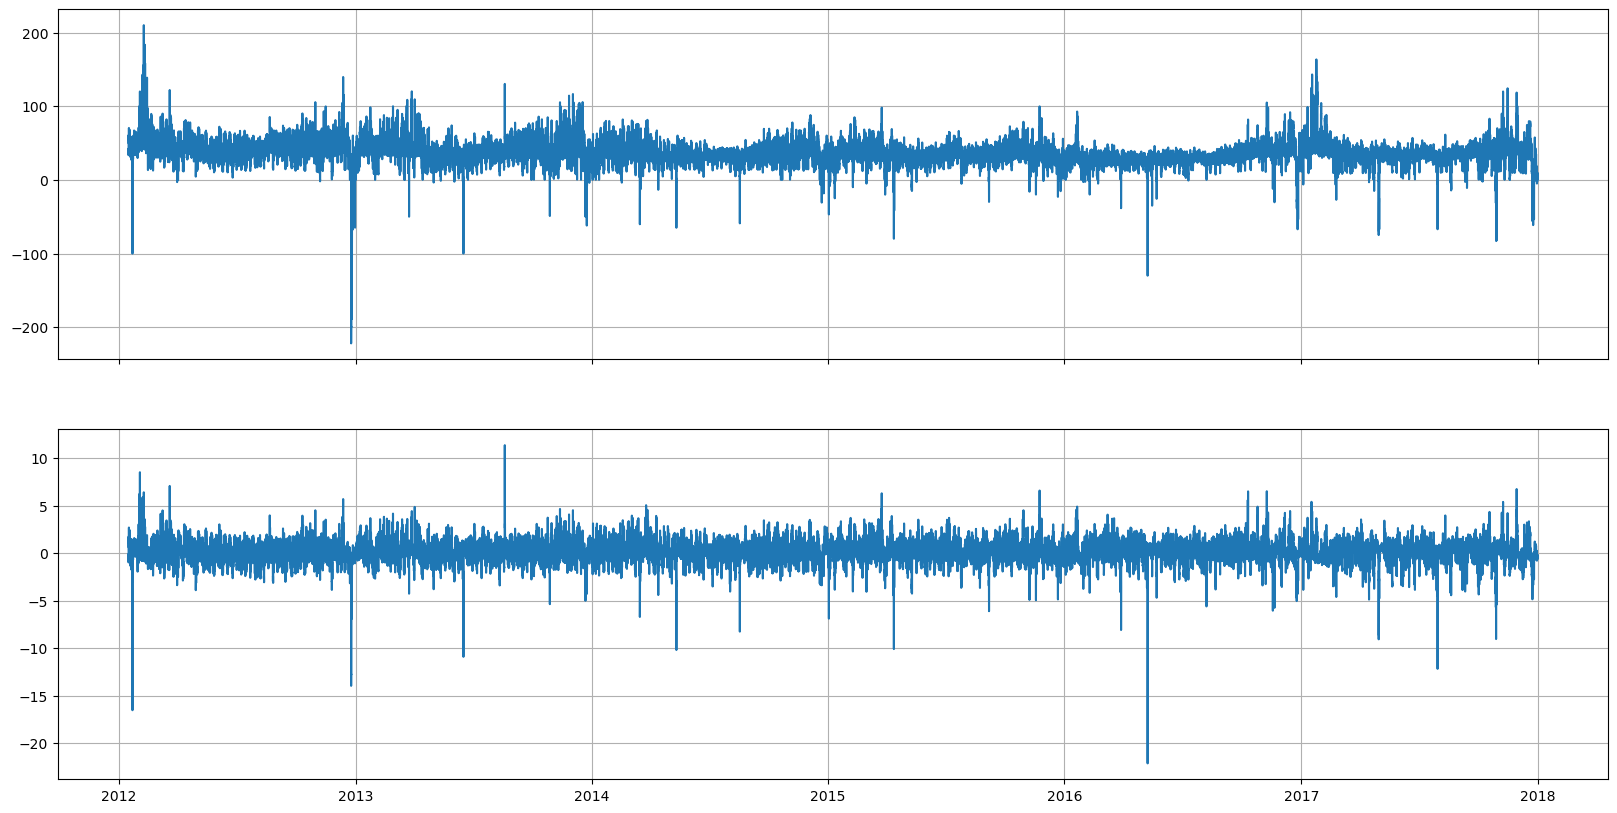

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(df_nuevo.Date, df_nuevo.Price_real)
ax[1].plot(df_nuevo.Date, df_nuevo.Price)
ax[0].grid()
ax[1].grid()

In [55]:
df_nuevo

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour,Price_24,Price_48,Price_72,Price_168,...,Exogenous 2_hora_23_168,scaler,Price_real,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2012-01-16 00:00:00,-0.132958,-1.232569,-1.335008,2012-01-16,0,-0.434663,-1.326931,-2.298884,NaN,...,NaN,StandardScaler(),41.94,1,0,0,0,0,0,0
1,2012-01-16 01:00:00,-0.356336,-1.234168,-1.524167,2012-01-16,1,-0.486951,-1.458760,-2.850089,NaN,...,NaN,StandardScaler(),39.69,1,0,0,0,0,0,0
2,2012-01-16 02:00:00,-0.524119,-1.225008,-1.578075,2012-01-16,2,-0.619096,-1.518598,-3.061933,NaN,...,NaN,StandardScaler(),38.00,1,0,0,0,0,0,0
3,2012-01-16 03:00:00,-0.962934,-1.217520,-1.516710,2012-01-16,3,-0.856768,-1.420427,-3.063990,NaN,...,NaN,StandardScaler(),33.58,1,0,0,0,0,0,0
4,2012-01-16 04:00:00,-0.973854,-1.215847,-1.427774,2012-01-16,4,-1.029794,-1.383028,-2.850089,NaN,...,NaN,StandardScaler(),33.47,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52243,2017-12-31 19:00:00,-0.227012,1.163122,-0.581634,2017-12-31,19,0.142942,0.598077,0.693209,-2.045686,...,-2.940779,StandardScaler(),7.92,0,0,0,0,0,0,1
52244,2017-12-31 20:00:00,-0.395554,1.038015,-0.798149,2017-12-31,20,-0.076151,0.527211,0.310480,-2.373483,...,-2.940779,StandardScaler(),4.06,0,0,0,0,0,0,1
52245,2017-12-31 21:00:00,-0.341411,0.981075,-0.889427,2017-12-31,21,-0.358585,0.446571,0.113880,-2.461025,...,-2.940779,StandardScaler(),5.30,0,0,0,0,0,0,1
52246,2017-12-31 22:00:00,-0.491614,1.004333,-0.833496,2017-12-31,22,-0.354681,0.462455,0.084022,-2.129337,...,-2.940779,StandardScaler(),1.86,0,0,0,0,0,0,1


In [56]:
df_nuevo = df_nuevo.drop(df_nuevo.head(24).index)

# Estandarización móvil + LEAR

In [57]:
with open('dict_new_df_de_epftoolbox_final.pkl', 'rb') as handle:
    dict_new_df = pickle.load(handle)

In [58]:
df_nuevo = pd.DataFrame(dict_new_df)

In [59]:
df_nuevo['Date'] = pd.to_datetime(df_nuevo.Date)

In [60]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [61]:
df_scalers

,Date,scaler
0,2012-01-16 00:00:00,StandardScaler()
1,2012-01-16 01:00:00,StandardScaler()
2,2012-01-16 02:00:00,StandardScaler()
3,2012-01-16 03:00:00,StandardScaler()
4,2012-01-16 04:00:00,StandardScaler()
...,...,...
52243,2017-12-31 19:00:00,StandardScaler()
52244,2017-12-31 20:00:00,StandardScaler()
52245,2017-12-31 21:00:00,StandardScaler()
52246,2017-12-31 22:00:00,StandardScaler()


In [62]:
df_nuevo = df_nuevo[['Date', 'Price', 'Exogenous 1', 'Exogenous 2']]

In [63]:
df = df_nuevo

In [64]:
df.index = df.Date

In [65]:
df = df.drop(['Date'], axis = 1)

In [66]:
df_train = df[df.index < dt.datetime(2016, 1, 1)]
df_test = df[df.index >= dt.datetime(2016, 1, 1)]

In [67]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [68]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [69]:
forecast_dates = forecast.index

In [70]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [71]:
calibration_window = 2*364

In [72]:
model = LEAR(calibration_window=calibration_window)

In [73]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [74]:
df_original = pd.read_csv(r"Data\EPFToolbox\DE.csv")

In [75]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [76]:
df_original.index = df_original.Date

In [77]:
df_original = df_original.drop('Date', axis = 1)

In [78]:
df.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [82]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [83]:
real_values = df_original[df_original.index >= dt.datetime(2016, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [84]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,23.86,22.39,20.59,16.81,17.41,17.02,15.86,18.16,17.73,19.77,...,25.00,24.43,28.87,37.44,37.41,35.34,33.07,29.52,30.10,24.57
2016-01-02,22.20,16.57,15.35,12.77,11.27,11.91,12.62,13.83,16.12,18.12,...,16.90,16.97,19.25,28.01,28.36,26.56,17.38,15.83,16.97,15.31
2016-01-03,6.99,-0.01,0.23,4.51,4.12,6.76,0.75,4.27,9.11,15.92,...,18.49,16.51,18.76,22.21,26.76,27.08,25.33,22.11,20.91,14.43
2016-01-04,13.78,12.77,10.56,3.87,3.20,8.67,18.01,28.52,34.74,33.46,...,34.94,34.92,38.00,41.21,42.95,41.96,34.94,30.66,30.00,23.90
2016-01-05,25.03,24.42,22.34,21.50,20.00,23.53,28.96,38.32,41.45,40.72,...,34.91,33.50,35.10,42.44,42.94,41.74,36.47,33.01,31.75,26.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,25.37,15.09,13.93,13.48,12.74,13.29,20.03,28.62,32.00,34.91,...,46.40,46.48,50.90,56.09,57.57,51.33,42.40,40.00,42.24,31.27
2017-12-28,28.87,28.12,27.20,26.00,26.33,28.89,30.74,35.98,38.43,39.93,...,36.42,40.03,42.98,43.01,42.16,34.93,25.06,19.99,19.22,5.86
2017-12-29,9.73,0.72,-0.93,1.07,1.00,2.91,3.60,15.97,29.69,30.20,...,30.02,31.00,32.98,34.95,32.79,30.23,28.49,26.51,26.90,15.06


In [85]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2016-01-01 - sMAPE: 30.25%  |  MAE: 9.562
2016-01-02 - sMAPE: 33.59%  |  MAE: 7.322
2016-01-03 - sMAPE: 36.99%  |  MAE: 6.073
2016-01-04 - sMAPE: 32.04%  |  MAE: 5.211
2016-01-05 - sMAPE: 27.75%  |  MAE: 4.762
2016-01-06 - sMAPE: 24.45%  |  MAE: 4.423
2016-01-07 - sMAPE: 22.78%  |  MAE: 4.376
2016-01-08 - sMAPE: 21.02%  |  MAE: 4.113
2016-01-09 - sMAPE: 19.60%  |  MAE: 3.923
2016-01-10 - sMAPE: 18.48%  |  MAE: 3.677
2016-01-11 - sMAPE: 17.37%  |  MAE: 3.531
2016-01-12 - sMAPE: 17.02%  |  MAE: 3.532
2016-01-13 - sMAPE: 16.24%  |  MAE: 3.420
2016-01-14 - sMAPE: 15.65%  |  MAE: 3.382
2016-01-15 - sMAPE: 15.37%  |  MAE: 3.430
2016-01-16 - sMAPE: 14.89%  |  MAE: 3.360
2016-01-17 - sMAPE: 14.66%  |  MAE: 3.332
2016-01-18 - sMAPE: 14.43%  |  MAE: 3.373
2016-01-19 - sMAPE: 14.76%  |  MAE: 3.702
2016-01-20 - sMAPE: 14.56%  |  MAE: 3.823
2016-01-21 - sMAPE: 14.30%  |  MAE: 3.888
2016-01-22 - sMAPE: 15.15%  |  MAE: 4.199
2016-01-23 - sMAPE: 16.37%  |  MAE: 4.393
2016-01-24 - sMAPE: 16.69%  |  MAE

2016-07-15 - sMAPE: 18.02%  |  MAE: 3.499
2016-07-16 - sMAPE: 17.96%  |  MAE: 3.490
2016-07-17 - sMAPE: 17.90%  |  MAE: 3.479
2016-07-18 - sMAPE: 17.84%  |  MAE: 3.469
2016-07-19 - sMAPE: 17.76%  |  MAE: 3.458
2016-07-20 - sMAPE: 17.71%  |  MAE: 3.450
2016-07-21 - sMAPE: 17.66%  |  MAE: 3.446
2016-07-22 - sMAPE: 17.59%  |  MAE: 3.432
2016-07-23 - sMAPE: 17.54%  |  MAE: 3.428
2016-07-24 - sMAPE: 17.48%  |  MAE: 3.418
2016-07-25 - sMAPE: 17.43%  |  MAE: 3.410
2016-07-26 - sMAPE: 17.36%  |  MAE: 3.399
2016-07-27 - sMAPE: 17.31%  |  MAE: 3.394
2016-07-28 - sMAPE: 17.24%  |  MAE: 3.382
2016-07-29 - sMAPE: 17.25%  |  MAE: 3.389
2016-07-30 - sMAPE: 17.18%  |  MAE: 3.378
2016-07-31 - sMAPE: 17.13%  |  MAE: 3.371
2016-08-01 - sMAPE: 17.08%  |  MAE: 3.362
2016-08-02 - sMAPE: 17.04%  |  MAE: 3.361
2016-08-03 - sMAPE: 16.99%  |  MAE: 3.354
2016-08-04 - sMAPE: 16.95%  |  MAE: 3.347
2016-08-05 - sMAPE: 16.90%  |  MAE: 3.340
2016-08-06 - sMAPE: 16.87%  |  MAE: 3.336
2016-08-07 - sMAPE: 17.07%  |  MAE

2017-01-27 - sMAPE: 17.05%  |  MAE: 4.254
2017-01-28 - sMAPE: 17.05%  |  MAE: 4.260
2017-01-29 - sMAPE: 17.15%  |  MAE: 4.284
2017-01-30 - sMAPE: 17.16%  |  MAE: 4.300
2017-01-31 - sMAPE: 17.15%  |  MAE: 4.315
2017-02-01 - sMAPE: 17.16%  |  MAE: 4.338
2017-02-02 - sMAPE: 17.15%  |  MAE: 4.342
2017-02-03 - sMAPE: 17.12%  |  MAE: 4.339
2017-02-04 - sMAPE: 17.11%  |  MAE: 4.341
2017-02-05 - sMAPE: 17.09%  |  MAE: 4.340
2017-02-06 - sMAPE: 17.08%  |  MAE: 4.350
2017-02-07 - sMAPE: 17.06%  |  MAE: 4.351
2017-02-08 - sMAPE: 17.05%  |  MAE: 4.361
2017-02-09 - sMAPE: 17.02%  |  MAE: 4.358
2017-02-10 - sMAPE: 17.01%  |  MAE: 4.364
2017-02-11 - sMAPE: 16.99%  |  MAE: 4.362
2017-02-12 - sMAPE: 17.01%  |  MAE: 4.367
2017-02-13 - sMAPE: 16.99%  |  MAE: 4.365
2017-02-14 - sMAPE: 16.99%  |  MAE: 4.373
2017-02-15 - sMAPE: 16.98%  |  MAE: 4.379
2017-02-16 - sMAPE: 16.98%  |  MAE: 4.384
2017-02-17 - sMAPE: 16.95%  |  MAE: 4.380
2017-02-18 - sMAPE: 16.93%  |  MAE: 4.378
2017-02-19 - sMAPE: 16.95%  |  MAE

2017-08-11 - sMAPE: 16.93%  |  MAE: 4.309
2017-08-12 - sMAPE: 16.92%  |  MAE: 4.304
2017-08-13 - sMAPE: 16.91%  |  MAE: 4.300
2017-08-14 - sMAPE: 16.88%  |  MAE: 4.295
2017-08-15 - sMAPE: 16.89%  |  MAE: 4.298
2017-08-16 - sMAPE: 16.88%  |  MAE: 4.296
2017-08-17 - sMAPE: 16.86%  |  MAE: 4.292
2017-08-18 - sMAPE: 16.84%  |  MAE: 4.287
2017-08-19 - sMAPE: 16.91%  |  MAE: 4.294
2017-08-20 - sMAPE: 17.01%  |  MAE: 4.297
2017-08-21 - sMAPE: 17.01%  |  MAE: 4.297
2017-08-22 - sMAPE: 16.99%  |  MAE: 4.294
2017-08-23 - sMAPE: 16.97%  |  MAE: 4.290
2017-08-24 - sMAPE: 16.96%  |  MAE: 4.288
2017-08-25 - sMAPE: 16.94%  |  MAE: 4.285
2017-08-26 - sMAPE: 16.95%  |  MAE: 4.286
2017-08-27 - sMAPE: 16.96%  |  MAE: 4.289
2017-08-28 - sMAPE: 16.94%  |  MAE: 4.285
2017-08-29 - sMAPE: 16.92%  |  MAE: 4.282
2017-08-30 - sMAPE: 16.91%  |  MAE: 4.279
2017-08-31 - sMAPE: 16.90%  |  MAE: 4.280
2017-09-01 - sMAPE: 16.88%  |  MAE: 4.275
2017-09-02 - sMAPE: 16.86%  |  MAE: 4.270
2017-09-03 - sMAPE: 16.84%  |  MAE

In [86]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,23.846014,20.733217,18.562951,16.596937,16.232126,18.42152,25.994513,40.568864,40.155395,40.149727,...,39.787971,40.600967,42.513323,49.409952,48.868488,47.820388,38.570517,32.87074,31.157017,24.883622
2016-01-02,21.713575,17.581022,16.293953,13.88136,12.186573,9.2603,3.072723,2.750424,6.274833,11.398382,...,10.264606,10.716506,13.841951,20.175159,20.878062,16.955371,14.634695,13.598034,17.236237,13.97001
2016-01-03,10.889436,7.204828,6.435353,6.157735,5.804077,5.499906,0.300408,3.433971,4.335393,9.927491,...,11.616807,11.704197,16.717136,24.00252,27.409891,25.224036,20.369309,19.07022,21.103759,16.633271
2016-01-04,11.0709,8.98996,7.40698,7.665284,8.494424,12.370304,21.228968,32.697543,33.59257,33.041076,...,30.75611,31.639004,34.401762,42.131481,43.725754,41.36127,37.056065,31.691882,29.225925,22.965122
2016-01-05,20.76309,19.373117,17.610843,17.25127,17.783487,20.379971,27.269611,41.797062,41.074983,41.547356,...,39.309262,39.666164,40.19972,44.442672,45.246531,42.568564,34.942685,29.031377,26.64636,20.876636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,2.322248,-2.24468,-6.260486,-8.585785,-7.136749,0.200131,13.6083,32.594808,34.025157,31.235257,...,26.301624,36.122589,42.705246,55.685192,57.563264,52.317195,41.133019,27.298524,16.540739,6.320086
2017-12-28,19.980962,17.198829,13.321882,10.113153,10.842541,14.168894,24.169023,38.184617,44.702786,41.906467,...,30.210856,33.841028,36.728078,44.748793,47.180421,36.769494,27.821724,21.462092,16.825625,8.017328
2017-12-29,1.114325,0.465202,-2.960972,-2.494005,2.27718,5.89089,15.399418,29.111478,34.415092,33.567242,...,28.53021,31.432154,35.871961,41.68341,40.560975,32.990216,25.625409,20.231904,16.317585,6.318839


In [87]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_de_epftoolbox_final_2_anos_ventana.csv")

In [88]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [89]:
forecast_dates = forecast.index

In [90]:
calibration_window = 1*364

In [91]:
model = LEAR(calibration_window=calibration_window)

In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2016-01-01 - sMAPE: 30.21%  |  MAE: 9.534
2016-01-02 - sMAPE: 29.40%  |  MAE: 6.794
2016-01-03 - sMAPE: 33.89%  |  MAE: 5.749
2016-01-04 - sMAPE: 30.01%  |  MAE: 5.098
2016-01-05 - sMAPE: 26.43%  |  MAE: 4.828
2016-01-06 - sMAPE: 23.75%  |  MAE: 4.615
2016-01-07 - sMAPE: 22.15%  |  MAE: 4.498
2016-01-08 - sMAPE: 20.78%  |  MAE: 4.281
2016-01-09 - sMAPE: 19.51%  |  MAE: 4.122
2016-01-10 - sMAPE: 18.72%  |  MAE: 3.918
2016-01-11 - sMAPE: 17.68%  |  MAE: 3.777
2016-01-12 - sMAPE: 17.37%  |  MAE: 3.786
2016-01-13 - sMAPE: 16.68%  |  MAE: 3.693
2016-01-14 - sMAPE: 15.98%  |  MAE: 3.609
2016-01-15 - sMAPE: 15.71%  |  MAE: 3.651
2016-01-16 - sMAPE: 15.33%  |  MAE: 3.602
2016-01-17 - sMAPE: 14.85%  |  MAE: 3.512
2016-01-18 - sMAPE: 14.76%  |  MAE: 3.606
2016-01-19 - sMAPE: 15.14%  |  MAE: 3.955
2016-01-20 - sMAPE: 15.04%  |  MAE: 4.111
2016-01-21 - sMAPE: 14.90%  |  MAE: 4.236
2016-01-22 - sMAPE: 16.03%  |  MAE: 4.576
2016-01-23 - sMAPE: 17.45%  |  MAE: 4.820
2016-01-24 - sMAPE: 17.56%  |  MAE

2016-07-15 - sMAPE: 18.83%  |  MAE: 3.758
2016-07-16 - sMAPE: 18.76%  |  MAE: 3.746
2016-07-17 - sMAPE: 18.70%  |  MAE: 3.733
2016-07-18 - sMAPE: 18.63%  |  MAE: 3.722
2016-07-19 - sMAPE: 18.55%  |  MAE: 3.710
2016-07-20 - sMAPE: 18.48%  |  MAE: 3.699
2016-07-21 - sMAPE: 18.43%  |  MAE: 3.693
2016-07-22 - sMAPE: 18.36%  |  MAE: 3.679
2016-07-23 - sMAPE: 18.31%  |  MAE: 3.672
2016-07-24 - sMAPE: 18.24%  |  MAE: 3.662
2016-07-25 - sMAPE: 18.19%  |  MAE: 3.655
2016-07-26 - sMAPE: 18.12%  |  MAE: 3.644
2016-07-27 - sMAPE: 18.07%  |  MAE: 3.638
2016-07-28 - sMAPE: 18.00%  |  MAE: 3.625
2016-07-29 - sMAPE: 18.01%  |  MAE: 3.633
2016-07-30 - sMAPE: 17.94%  |  MAE: 3.621
2016-07-31 - sMAPE: 17.90%  |  MAE: 3.614
2016-08-01 - sMAPE: 17.83%  |  MAE: 3.603
2016-08-02 - sMAPE: 17.80%  |  MAE: 3.602
2016-08-03 - sMAPE: 17.75%  |  MAE: 3.595
2016-08-04 - sMAPE: 17.70%  |  MAE: 3.587
2016-08-05 - sMAPE: 17.65%  |  MAE: 3.580
2016-08-06 - sMAPE: 17.62%  |  MAE: 3.575
2016-08-07 - sMAPE: 17.82%  |  MAE

In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_de_epftoolbox_final_1_ano_ventana.csv")

In [ ]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [ ]:
forecast_dates = forecast.index

In [ ]:
calibration_window = 182

In [ ]:
model = LEAR(calibration_window=calibration_window)

In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_de_epftoolbox_final_6_meses_ventana.csv")

In [ ]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [ ]:
forecast_dates = forecast.index

In [ ]:
calibration_window = None

In [ ]:
model = LEAR(calibration_window=calibration_window)

In [ ]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

In [ ]:
forecast

In [ ]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_de_epftoolbox_final_sin_ventana.csv")